In [1]:
from unityagents import UnityEnvironment
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import RAdam

from agent import Agent


%matplotlib inline

cuda:0


In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.06999999843537807


In [6]:
def runner(n_episodes=200, max_t=1000, print_every=1, train_mode=True,
         checkpoint_actor='checkpoint_actor.pth', checkpoint_critic='checkpoint_critic.pth'):

    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=100)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
        
                  
        if moving_avgs[-1] >= 30.0 and i_episode >= 100:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-100, moving_avgs[-1], 100))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), checkpoint_actor)
                torch.save(agent.critic_local.state_dict(), checkpoint_critic)  
            break
            
    return mean_scores, moving_avgs

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores, avgs = runner()

Episode 1 (160 sec)  -- 	Min: 0.2	Max: 1.9	Mean: 0.9	Mov. Avg: 0.9
Episode 2 (168 sec)  -- 	Min: 0.9	Max: 5.5	Mean: 2.6	Mov. Avg: 1.8
Episode 3 (163 sec)  -- 	Min: 1.1	Max: 4.5	Mean: 2.6	Mov. Avg: 2.0
Episode 4 (166 sec)  -- 	Min: 0.5	Max: 7.6	Mean: 4.4	Mov. Avg: 2.6
Episode 5 (166 sec)  -- 	Min: 2.1	Max: 11.8	Mean: 5.8	Mov. Avg: 3.2
Episode 6 (170 sec)  -- 	Min: 4.0	Max: 15.3	Mean: 8.5	Mov. Avg: 4.1
Episode 7 (169 sec)  -- 	Min: 3.9	Max: 16.0	Mean: 9.0	Mov. Avg: 4.8
Episode 8 (175 sec)  -- 	Min: 4.0	Max: 17.2	Mean: 10.6	Mov. Avg: 5.5
Episode 9 (171 sec)  -- 	Min: 2.4	Max: 25.9	Mean: 14.6	Mov. Avg: 6.5
Episode 10 (179 sec)  -- 	Min: 4.8	Max: 20.1	Mean: 12.2	Mov. Avg: 7.1
Episode 11 (180 sec)  -- 	Min: 3.9	Max: 27.7	Mean: 13.9	Mov. Avg: 7.7
Episode 12 (182 sec)  -- 	Min: 4.4	Max: 31.5	Mean: 19.0	Mov. Avg: 8.7
Episode 13 (178 sec)  -- 	Min: 7.6	Max: 32.2	Mean: 19.2	Mov. Avg: 9.5
Episode 14 (178 sec)  -- 	Min: 5.4	Max: 27.8	Mean: 17.3	Mov. Avg: 10.0
Episode 15 (189 sec)  -- 	Min: 4.6	Max:

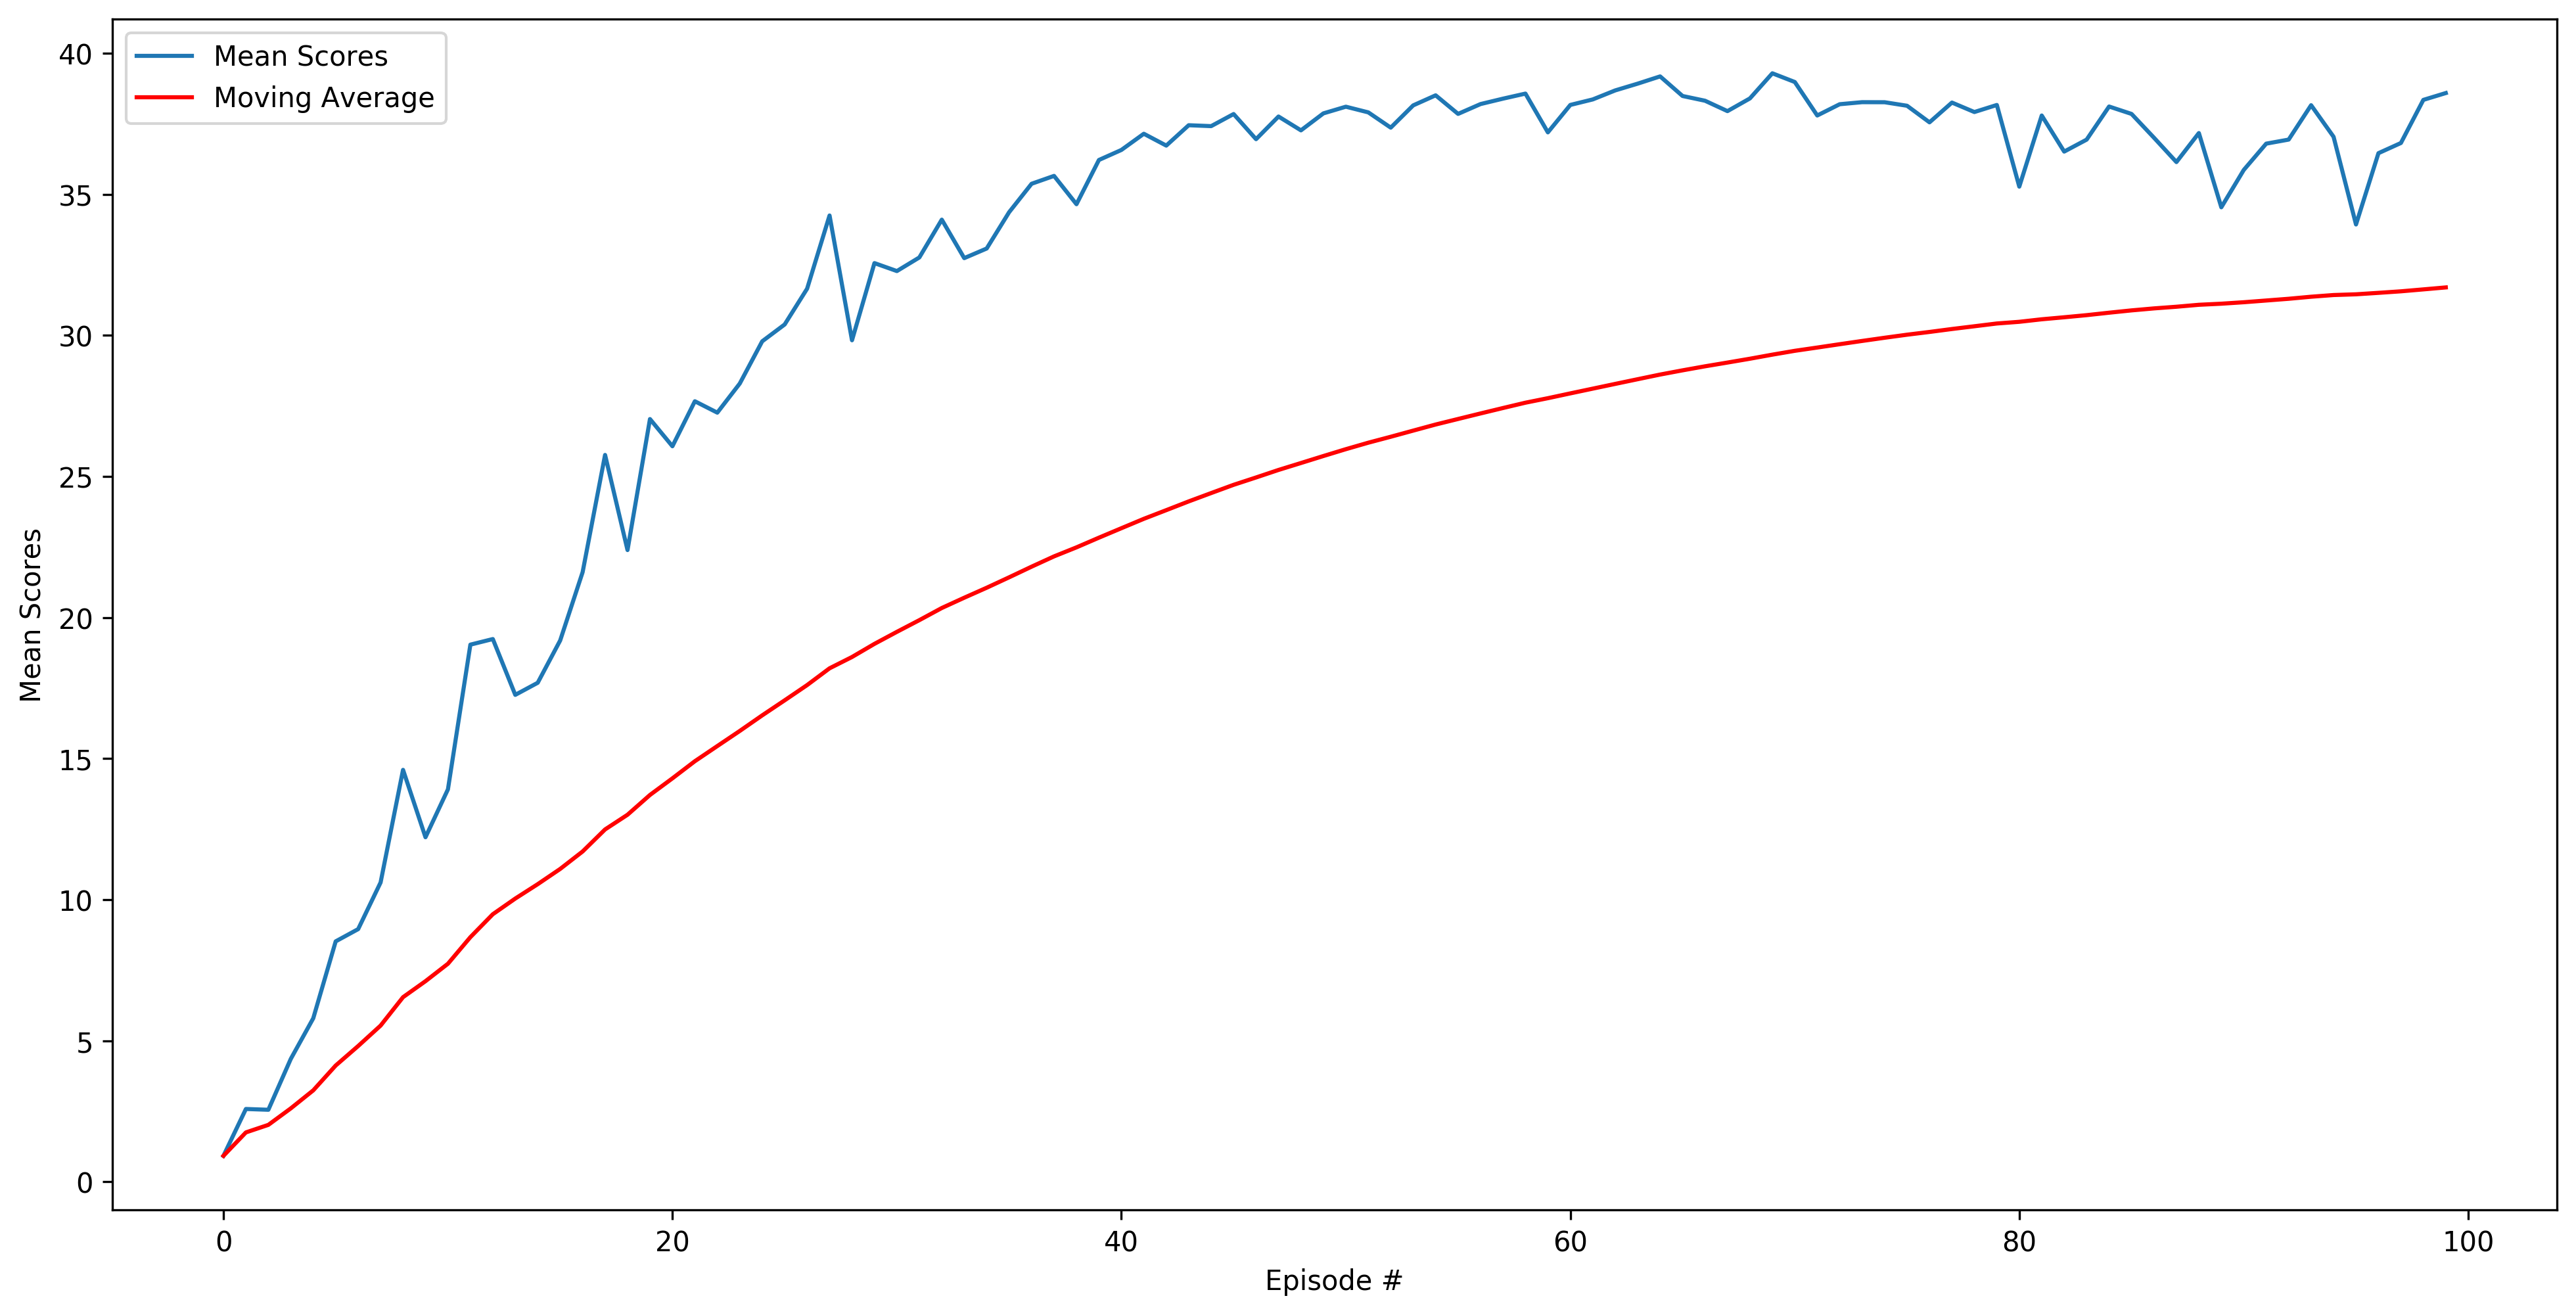

In [8]:
fig = plt.figure(figsize=(16,8),dpi=300)
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Mean Scores')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving Average')
plt.ylabel('Mean Scores')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [ ]:
scores, avgs = runner(n_episodes=10, train_mode=False)

Episode 1 (298 sec)  -- 	Min: 34.0	Max: 39.6	Mean: 38.0	Mov. Avg: 38.0
Episode 2 (299 sec)  -- 	Min: 33.2	Max: 39.4	Mean: 37.3	Mov. Avg: 37.6
Episode 3 (295 sec)  -- 	Min: 36.0	Max: 39.1	Mean: 37.6	Mov. Avg: 37.6
Episode 4 (300 sec)  -- 	Min: 28.7	Max: 39.2	Mean: 37.5	Mov. Avg: 37.6


In [ ]:
env.close()